In [493]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import scipy
import datetime
from datetime import datetime
from dateutil.rrule import rrule, MONTHLY
from mpl_toolkits.basemap import Basemap,maskoceans,interp,shiftgrid
from scipy import stats
import sys
sys.path.append('/Users/allen/Documents/Python/PlotGallary')
from matplotlibconfig import basic
#configure plot
basic()
import warnings
warnings.simplefilter('ignore')

# Question 1

__For this problem, you will again use SfcTAnomalies-1950-Present.nc along with ENSO.txt__

(a) To start, find the best-fit between ENSO and global-mean temperatures; i.e., is the best fit the comtemporaneous relationship or a lagged relationship? To do so, plot the lag correlation coefficient between ENSO and global-mean temperatures for all lags between -12 months to +12 months. Here, negative lags mean that ENSO leads global-mean temporature and positive lags mean that ENSO lags global-mean temporature. To calculate lag correlations, remember that you have to truncate the time series for compitations. At what lag does the "best" correlation between ENSO and global-mean temporature exits? Show a plot to justify your choice, including what the correlation coefficient for 90% significance is.

In [494]:
surfT= {}
with Dataset('SfcTAnomalies-1950-Present.nc', 'r') as nc:
    surfT['lons']= np.array(nc.variables['lon'][:])
    surfT['lats']= np.array(nc.variables['lat'][:])
    time= nc.variables['time'][:]
    timeUnits= nc.variables['time'].units
    surfT['date']= num2date(time, timeUnits, calendar='standard')
    surfT['month']= np.array([date.month for date in surfT['date']])
    surfT['year']= np.array([date.year for date in surfT['date']])
    ano= np.array(nc.variables['surfT'][:])
    ano[ano<-0]= np.nan #remove non-sense data
    surfT['ano']= ano    
    weights= np.cos(surfT['lats']/360*2*np.pi)/np.cos(surfT['lats']/360*2*np.pi).sum() #cos-lat mean
    _latMean= np.nansum((surfT['ano'].transpose(0,2,1)*weights),axis=2)
    surfT['mean'] = np.nanmean(_latMean, axis=1)

In [495]:
ENSO= {}
ENSOfile= np.loadtxt('ENSO.txt', skiprows=2)
ENSO['year']= ENSOfile[:,0]
ENSO['month']= ENSOfile[:,1]
ENSO['index']= ENSOfile[:,2] 

In [496]:
def detrend(y):
    '''
    linear regression to detrend
    
    Args:
    -------------------
    :y - numpy.ndarray; target to detrend
    
    Returns:
    -------------------
    :detrend - numpy.ndarray; 
    '''
    
    t= np.arange(len(y))
    E= np.ones((t.size,2))*np.nan
    E[:,0] = t
    E[:,1] = 1
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(y)
    trend = E.dot(xhat)
    detrend= y- trend
    
    return detrend, xhat

def corr(x,y, t, p=None):
    '''
    Compute t-lag correlation coefficient (1-dimension)
    
    Args:
    -----------------------
    :x - numpy.ndarray; sample 1
    :y - numpy.ndarray; sample 2
    :t - int; t lag
    :p - int; percentile of confidence level for the correlation
    
    Returns:
    -------------------
    :r - float; correlation coefficient
    :t - float; t-score for computing significance
    :r_sig - float; correlation coefficient within p confidence interval
    '''
    assert len(x)==len(y), 'sample should have the same length,\
                            but got %d for sample 1 and %d for sample 2'%(len(x), len(y))
    size= len(x)
    if t<0:
        _x= x[:size-abs(t)]
        _y= y[abs(t):]
    else:
        _x= x[t:]
        _y= y[: size-t]
    
    #compute effective sample sizes Source: Bretherton et al., 1999
    s_x = 1. # The index is standardized, so it's standard deviation is 1.
    s_y = np.nanstd(_y) 
    r= np.dot(_x[:,None].T, _y[:, None])/float(size-1)/np.std(_y)
    r1= np.dot(_x[:-1,None].T,_x[1:,None])/float(size-1)/s_x/s_x
    r2= np.dot(_y[:-1, None].T,_y[1:, None])/float(size-1)/s_y/s_y
    Neff= size*(1-r1*r2)/(1+r1*r2)
    
    t= r*(np.sqrt(Neff-2))/(1-r**2)**.5
    
    if p:
        #compute r within confidence interval
        z=1/2*np.log((1+r)/(1-r)) #Fischer's z-transform to unskew data distribution
        z_score= stats.norm.ppf((1+p)/2) # assume normal distribution
        mu_pos= z+z_score*(1/np.sqrt(size-3))
        mu_neg= z-z_score*(1/np.sqrt(size-3))

        upperBounds= (np.exp(2*mu_pos)-1)/(np.exp(2*mu_pos)+1)
        lowerBounds= (np.exp(2*mu_neg)-1)/(np.exp(2*mu_neg)+1)
        
    
    return r, t, upperBounds, lowerBounds

In [497]:
# detrend for surfTMean and ENSO
surfT['detrend'],_ = detrend(surfT['mean'])
ENSO['detrend'],_= detrend(ENSO['index'])

# standardize ENSO
ENSO['stdIndex']= (ENSO['detrend']- ENSO['detrend'].mean())/ENSO['detrend'].std()

In [498]:
results= {
    'lag': [],
    'corr': [],
    't_score': [],
    'upper': [],
    'lower': [],
}
for t in range(-12,13):
    _corrcoef, _t_score, _upper, _lower= corr(ENSO['stdIndex'], surfT['detrend'], t, .9)
    results['lag'].append(t)
    results['corr'].append(_corrcoef.squeeze())
    results['t_score'].append(_t_score)
    results['upper'].append(_upper.squeeze())
    results['lower'].append(_lower.squeeze())

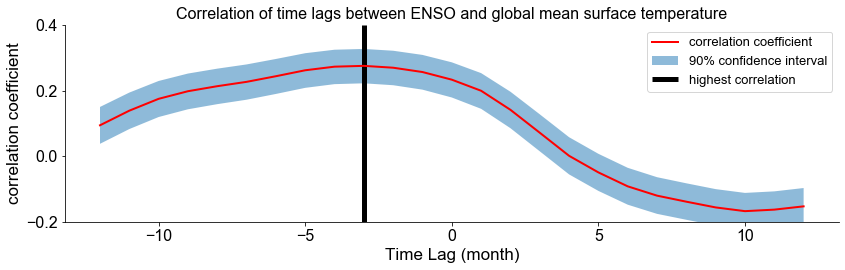

In [29]:
fig, ax= plt.subplots(1,1, figsize=(12,4))
ax.plot(results['lag'], results['corr'], color='r', label='correlation coefficient')
ax.fill_between(results['lag'], results['upper'], results['lower'], alpha=.5, label='90% confidence interval')

ax.set_xlabel('Time Lag (month)')
ax.set_ylabel('correlation coefficient')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.vlines(results['lag'][np.argmax(np.array(results['corr']))],
          -.2, .4, linewidth=5, label='highest correlation')
ax.legend()
ax.set_ylim([-.2, .4])
ax.set_title('Correlation of time lags between ENSO and global mean surface temperature');

<p align="center">
    Fig.1 Correlation of time lags between ENSO and global mean sea surface temperature. Positive time lag means ENSO lags global mean temperature and negative lag means ENSO leads global mean temperature. The maximum correlation occurs when ENSO lags 3 months. The 90% confidence interval at 3 month time lag is [0.22(left), 0.33(right)].
</p>

(b) Using (a), calculate the regression coefficient between global-mean temperature (i.e., used a weighted mean, with the weights being cosine latitude) and the ENSO index. The units will be K/std. Make sure to use the right lag and apply it correctly! Then, calculate the ENSO-residual global-mean temperature time seriies; i.e., the global-mean temperautre minus the fitted (and lagged if necessary) ENSO time series: $y_{residual}=y-y_{ENSO-fit}$. Make a plot of all three time series as three separate subplots in the same figure: (a) global-mean temperautre; (2) the fitted (and lagged if any) time series with ENSO; and (3) the residual time series. Stack the plots on top of each other in the order depicted.

In [35]:
def model(x, y):
    '''Linear regression model'''
    E= np.zeros((len(x), 2))
    E[:,0]= 1
    E[:,1]= x
#     E[:, 2]= np.cos(2.*np.pi*x/12.)
    invETE = np.linalg.inv(np.dot(E.T,E))
    xhat = invETE.dot(E.T).dot(y)
    yhat = np.dot(E,xhat)
    
    return xhat, yhat

# use the optimal time lag computed in (a)
x= (ENSO['index'][:-3]- np.nanmean(ENSO['index'][:-4]))/np.nanstd(ENSO['index'][:-3])
coef, yreconstruct= model(ENSO['index'][:-3], surfT['mean'][3:])
residual= surfT['mean'][3:]- yreconstruct

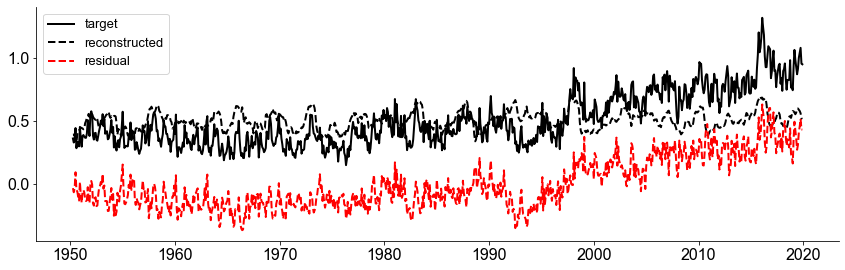

In [36]:
fig, ax= plt.subplots(1,1,figsize=(12,4))
ax.plot(surfT['date'][3:], surfT['mean'][3:], c='k', label='target')
# ax.set_title('Global mean surface temperautre')
ax.plot(surfT['date'][3:], yreconstruct, 'k--', label='reconstructed')
# ax.set_title('Reconstructed')
ax.plot(surfT['date'][3:], residual, 'r--', label='residual')
# ax.set_title('Residuals')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

<p align="center">Fig.2 Performance of reconstructed global mean temperature with ENSO.</p>          

Now, determine whether ENSO has impacted recent global climate change. To do so, calculate the linear trends in the raw, ENSO-fitted, and residual global-mean time series. Express the trends in K/decade. In your write-up (2-3 paragraphs), address the following: (i) How you performed the analysis; (ii) The lag between ENSO and global mean-temperture; (iii) what fraction of month-to-month variability in global-mean temperature is linearly related to ENSO?; (iv) Whether you think ENSO has contributed to global climate change.

In [48]:
coef_raw= detrend(surfT['mean'])[1][0]
coef_ENSO= detrend(yreconstruct)[1][0]
coef_res= detrend(residual)[1][0]

print('Slope for raw, ENSO-fitted global mean-temperature and residual global\
      mean-temperature are equivalent to %.2f,\
      %.2f, %.2f K/decade'%(coef_raw*12*100,
                            coef_ENSO*12*100, coef_res*12*100))

Slope for raw, ENSO-fitted global mean-temperature and residual global      mean-temperature are equivalent to 0.80,      0.07, 0.74 K/decade


__Summary__

To find out the best correlated time lag between ENSO and global-mean temperautre, first both ENSO and global mean temperature are detrended in order to remove the contribution of strong trend in the result (i.e., strong trend may skew the correlation). After that, correlation coefficient is computed by sliding with different time windows to get a distribution of correlation dependent upon time lags (i.e. Figure 1). As the result suggests, the optimal time lag is when ENSO lags the global mean temperature 3 months.

Based upon the optimal time lag, linear regression is constructed with this lagged relation. The target (i.e., global mean temperature in thick black), ENSO-fitted (in dashed black), and residuals (in red) are presented in Figure 2. The model predicts well before 1990 but does not capture the trend as the residual increases afterwards. The trend for global mean temperature, ENSO-fitted and residuals are 0.8, 0.1, and 0.7 K/decade, respectively. Given this model, we are not able to state the ENSO contributes to the global climate change because the model cannot foresee that.

# Question 2

Let's investigate some more about red noise time series and red noise processes.

(a) Generate these standardized red noise time seris of length N=5000. Time series #1 (T1) will have a lag-one autocorrelation of $r_1=0.1$, $T_2$ has a lag-one autocorrelaiton of $r_1=0.6$, and $T_3$ a lag-one auto-correlation of $r_1=0.9$. Plot each time series in a three-panel plot

In [263]:
def red_noise(N, r):
    '''
    This function generates red noise based on
    the autocorrelation
    
    Args:
    --------------------
    :r - float; lag-1 auto-correlation
    
    Returns:
    --------------------
    :arr - numpy.ndarray
    '''
    white= np.random.normal(0,1,size=N)
    arr= np.zeros(N)
    arr[0]= white[0]
    for i in range(N-1):
        arr[i+1]= r*arr[i]+(1-r**2)**.5* white[i+1]
    return arr

In [268]:
arr1= red_noise(5000,.1)
arr2= red_noise(5000, .6)
arr3= red_noise(5000, .9)

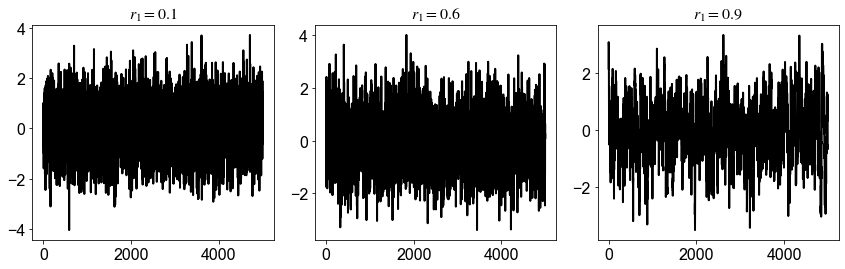

In [272]:
fig, ax= plt.subplots(1,3,figsize=(12,4))
ax[0].plot(np.arange(5000), arr1, c='k')
ax[0].set_title('$r_1=0.1$')
ax[1].plot(np.arange(5000), arr2, c='k')
ax[1].set_title('$r_1=0.6$')
ax[2].plot(np.arange(5000), arr3, c='k')
ax[2].set_title('$r_1=0.9$');

<p align="center">
    Fig.3 Generated red noise plot for three lag-1 autocorrelations: 0.1; 0.6; and 0.9.
</p>

(b) Next assume the mean is 0 and standard deviation =1 of the N=5000 time series represent the population values of these statistics. Determine the effect of persistence of the estimate of these statistics based on samples of size n=100. Here is one way to do this: For each time series T1, T2, and T3:

    1. Draw a random sample consisting of 100 consecutive elements from the full time series. Calculate the mean and standard deviation of the sample, and save that value;
    2. Repeat step 1 10,000 times;
    3. Plot the histogram of the sampling distribution of the means and standard deviateions found in Step #1 and #2 above;
    
Discuss your results (2-3 paragrahs). In the discussion, address the following: (1) Assuming the sample size is fixed, what is the impact of persistence on the distribution of sample means?; (2) How does persistence impact the uncertainty of the sample mean?; (3) What is the impact of persistence on the estimate of the population standard deviation?; (4) How will ignoring persistence in a pair of time series impact the significance of the correlation between those time series?

In [289]:
num_iter= 10000
means= {
    'arr1': [],
    'arr2': [],
    'arr3': [],
}
stds = {
    'arr1': [],
    'arr2': [],
    'arr3': [],
}
for i in range(num_iter):
    choice= np.random.randint(0,4900)
    subset1= arr1[choice:choice+100]
    choice= np.random.randint(0,4900)
    subset2= arr2[choice:choice+100]
    choice= np.random.randint(0,4900)
    subset3= arr3[choice:choice+100]
    means['arr1'].append(subset1.mean())
    means['arr2'].append(subset2.mean())
    means['arr3'].append(subset3.mean())
    
    stds['arr1'].append(subset1.std())
    stds['arr2'].append(subset2.std())
    stds['arr3'].append(subset3.std())


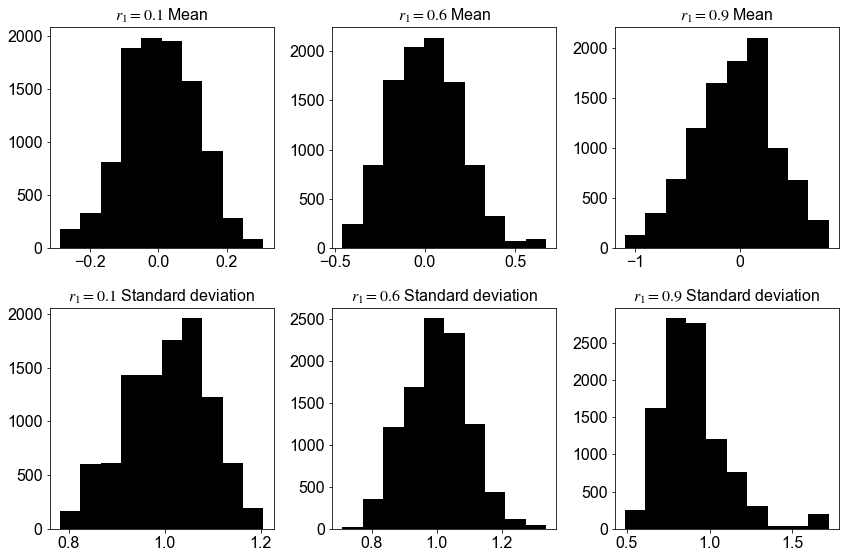

In [290]:
fig, ax= plt.subplots(2,3,figsize=(12,8))
ax[0,0].hist(means['arr1'], color='k')
ax[0,0].set_title('$r_1=0.1$ Mean')
ax[0,1].hist(means['arr2'], color='k')
ax[0,1].set_title('$r_1=0.6$ Mean')
ax[0,2].hist(means['arr3'], color='k')
ax[0,2].set_title('$r_1=0.9$ Mean');

ax[1,0].hist(stds['arr1'], color='k')
ax[1,0].set_title('$r_1=0.1$ Standard deviation')
ax[1,1].hist(stds['arr2'], color='k')
ax[1,1].set_title('$r_1=0.6$ Standard deviation')
ax[1,2].hist(stds['arr3'], color='k')
ax[1,2].set_title('$r_1=0.9$ Standard deviation');

<p align="center">
    Fig.4 The histogram of sample mean and standard deviation from selected consecutive 100 elements.
</p>

__Summary__:

The mean of the sample is spreading (higher uncertainties) with higher auto-correlation even though still higher density in new zero. The same story for standard deviation that it is spreading by adding more autocorrelations (persistences).

It is expected the results will be certainly biased if ignoring persistence in the time series analysis. Some signals might be incorrectly catched because persistence gives higher uncertainties in the model.

**Important**:

You found that the mean of std is shifted to around 0.8 for high persistence model! That explains why the r increases because $r=\frac{\bar{xy}}{S_xS_y}$! Remember to standardize in order to get rid of this bias.

# Question 3

Let's build a simple seasonal forecast model for sea surface temperature (SST) anomalies (SSTa) using two predictors: the February-April (FMA)-averaged North Pacific Meridional Mode (NPMM) and the FMA-averaged South Pacific Meridional Mode (SPMM). Specifically, you will be testing the forecasting skill of using the two meridional mode indices during FMA to predict the following November - January (NDJ(+1)) and the SPMM for forecasting the NDF-average 1950-51 SSTa field. The files NPMM.txt and SPMM.txt contain the monthly-mean values (in standardized units) of the NPMM and SPMM, respectively. You will also use the __SSTs-1950-Present.nc__ file for SSTs (Note: Missing values in the file mean land points). Think of this forecasting model as a multi-linear regression problem. Also, make all plots for the region 100E-60W, 65S-65N.

(a) First, calculate and plot the correlation coefficients between NDJ(+1)-averaged SSTa and each of the FMA-averaged indices separately as a function of space (i.e., two different plots/maps). You will start with FMA 1950 for this calculation and go through NDJ(+1) 2017-18. To calculate SSTa, remove the seasonal cycle from all grid points and use the 1981-2010 base period for climatology. Remember to detrend all data before computing the correlation. Indicate on your plots where te correlation coefficients are significant at the p<0.05 level using a Monte Carlo test.

In [213]:
# read in files
SST= {}
with Dataset('SSTs-1950-Present.nc', 'r') as nc:
    SST['lons']= np.array(nc.variables['lon'][:])
    SST['lats']= np.array(nc.variables['lat'][:])
    time= nc.variables['time'][:]
    timeUnits= nc.variables['time'].units
    SST['date']= num2date(time, timeUnits, calendar='standard')
    SST['month']= np.array([date.month for date in SST['date']])
    SST['year']= np.array([date.year for date in SST['date']])
    _sst= np.array(nc.variables['sst'][:])
    _sst[_sst<0]=np.nan
    SST['sst']= _sst

SSTbase= SST['sst']
NPMM= np.loadtxt('NPMM.txt', skiprows=2)    
SPMM= np.loadtxt('SPMM.txt', skiprows=2)
#since NPMM and SPMM have the same time stamp
year= NPMM[:,0]
month= NPMM[:,1]
NPMMIndex= NPMM[:,2]
SPMMIndex= SPMM[:,2]



In [231]:
# calculate monthly anomaly

SSTa= np.zeros(SSTbase.shape)
for i in np.arange(1,13):
    clim= np.where((year>=1981) & (year<=2010) & (month==i))
    x= np.where(SST['month']==i)[0]
    SSTa[x,:,:]= SSTbase[x,:,:]- np.nanmean(SSTbase[clim], axis=0)
# SSTa= SSTbase - np.nanmean(SSTbase[clim], axis=0)

# calculate NDJ mean
ndjSSTa= np.zeros((3, len(range(1950, 2018)), SSTa.shape[1], SSTa.shape[2]))*np.nan
ndjSSTa[0]= SSTa[np.where((month==11) & (year>=1950) & (year<=2017))]
ndjSSTa[1]= SSTa[np.where((month==12) & (year>=1950) & (year<=2017))]
ndjSSTa[2]= SSTa[np.where((month==1) & (year>=1951) & (year<=2018))]
ndjSSTa= np.nanmean(ndjSSTa, axis=0)

fmaNPMM= np.zeros((3, len(range(1950,2018))))*np.nan
fmaNPMM[0]= NPMMIndex[np.where((month==2) & (year>=1950) & (year<=2017))]
fmaNPMM[1]= NPMMIndex[np.where((month==2) & (year>=1950) & (year<=2017))]
fmaNPMM[2]= NPMMIndex[np.where((month==2) & (year>=1950) & (year<=2017))]
fmaNPMM= np.nanmean(fmaNPMM,axis=0)
fmaSPMM= np.zeros((3, len(range(1950,2018))))*np.nan
fmaSPMM[0]= SPMMIndex[np.where((month==2) & (year>=1950) & (year<=2017))]
fmaSPMM[1]= SPMMIndex[np.where((month==2) & (year>=1950) & (year<=2017))]
fmaSPMM[2]= SPMMIndex[np.where((month==2) & (year>=1950) & (year<=2017))]
fmaSPMM= np.nanmean(fmaSPMM, axis=0)

In [233]:
# detrend
ndjSSTa,_= detrend(ndjSSTa.reshape((len(ndjSSTa), -1), order='F'))

fmaNPMM,_= detrend(fmaNPMM)
fmaSPMM,_= detrend(fmaSPMM)

# standardize indices
fmaNPMM= (fmaNPMM - np.nanmean(fmaNPMM))/np.nanstd(fmaNPMM)
fmaSPMM= (fmaSPMM - np.nanmean(fmaSPMM))/np.nanstd(fmaSPMM)

assert len(ndjSSTa)==len(fmaNPMM), print(ndjSSTa.shape)

In [450]:
def corrcoef(x,y):
    '''
    Compute the correlation coefficient spatially
    
    Args:
    --------------------
    :x - np.ndarray; shape (space, ); predictor (standardized index);
    :y - np.ndarray; shape (time, space, order='F'); target;
    
    Returns:
    --------------------
    :corr - np.ndarray; shape(space, order='F'); correlation coeffcients
    '''
    T, N= y.shape
    
    #build linear regressor
    E = np.ones((T,2))*np.nan
    E[:,0] = x.copy()
    E[:,1] = 1

    xhat = np.linalg.inv(E.T.dot(E)).dot(E.T).dot(y)

    # Compute the "best fit" for SLP using the linear regression model (i.e., yhat)
    yhat = E.dot(xhat)
    
    totalVar= 1/len(y)*((y-y.mean(axis=0))**2).sum(axis=0)
    explainedVar= 1/len(yhat)*(((yhat-y.mean(axis=0))**2)).sum(axis=0)
    R2 = explainedVar/totalVar
    corr = np.sign(xhat[0,:])*np.sqrt(R2)
    s_x= np.nanstd(x)
    s_y= np.nanstd(y, axis=0)
    r= np.dot(y.T,x)/float(T)/s_y/s_x
    return corr
    


def monteCarloTest(trials, y, x, corr):
    '''Monte Carlo simulaitons'''
    n= trials
    mcCorr= np.zeros((len(corr), n))*np.nan
    
    taxis= np.arange(len(y))
    s_x= np.nanstd(x)
    s_y= np.nanstd(y, axis=0)
    T,N= y.shape

    for i in range(n):
        np.random.shuffle(taxis)
        mcCorr[:,i] = np.dot(y[taxis,:].T,x)/float(T)/s_y/s_x

    pvals = np.array([stats.percentileofscore(mcCorr[i,:], corr[i])/100. for i in range(len(corr))])
    
    return pvals

def visualize(lon, lat, data, stipple=None, **figkwargs):
    """
    Args:
    ---------------
    :figkwargs - dict; {
                        'ylabel': '',
                        'cmap': 'seismic',
                        'cRange': (-1,1),
                        'title': '',
                        'extent': tuple; (llclon, llclat, urclon, urclat)
                        'projection': str; default 'npstere'
                        }
    """
    
    ylabel= figkwargs.get('ylabel', '')
    cmapName= figkwargs.get('cmap', 'seismic')
    cRange= figkwargs.get('cRange', (-1,1))
    title= figkwargs.get('title', '')
    lllon, lllat, urlon, urlat= figkwargs.get('extent', (-180, -90, 180, 90))
    proj= figkwargs.get('projection', 'npstere')
    
    if proj!='npstere':
        rnd= False
    else: rnd=True
    
    
    cmin = cRange[0]; cmax = cRange[1];
    cint = 0.2; clevs = np.round(np.arange(cmin,cmax,cint),1)
    nlevs = len(clevs)-1
    
    plt.gca()
    cmap = plt.get_cmap(name= cmapName,lut=nlevs) 
    m = Basemap(projection='cyl',
            llcrnrlat=-65,urcrnrlat=65,llcrnrlon=-360,urcrnrlon=0,resolution='l')
    
    x,y = m(lon,lat)
    m.drawcoastlines(linewidth=3)
    m.drawmapboundary(linewidth=2)
#     m.drawmeridians(range(-90, 90, 10))
#     m.drawparallels(range(-360, 0, 20))
    if stipple is not None:
        m.plot(x[stipple], y[stipple],'o',color='Gold',markersize=1.5) #
    cs = m.contourf(x, y, data, cmap=cmap)
    cbar = m.colorbar(cs,size='2%')
    cbar.ax.set_ylabel(ylabel) 
    plt.title(title,name='Arial',weight='bold',size=20)
    
    return m

In [235]:
#compute correlation 
corrNPMM= corrcoef(fmaNPMM, ndjSSTa)
corrSPMM= corrcoef(fmaSPMM, ndjSSTa)
pvalsNPMM= monteCarloTest(5000, ndjSSTa, fmaNPMM, corrNPMM)
pvalsSPMM= monteCarloTest(5000, ndjSSTa, fmaSPMM, corrSPMM)

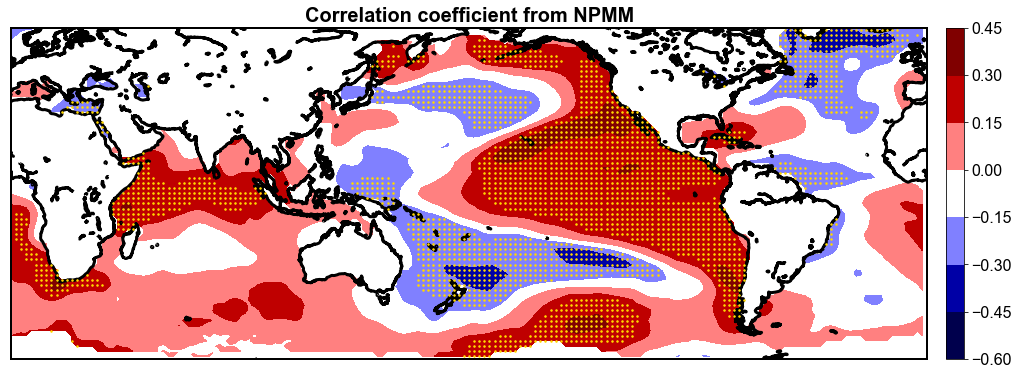

In [366]:
x, y= np.meshgrid(SST['lons'],SST['lats'])
stipple= ((pvalsNPMM<0.05) | (pvalsNPMM>0.95))
visualize(x, y, corrNPMM.reshape(89,180, order='F'), stipple= stipple.reshape(89,180, order='F'),
          title='Correlation coefficient from NPMM');

Fig.5 Correlation coefficient from predictor NPMM with yellow stupples standing for 95% significance with Monte Carlo test.

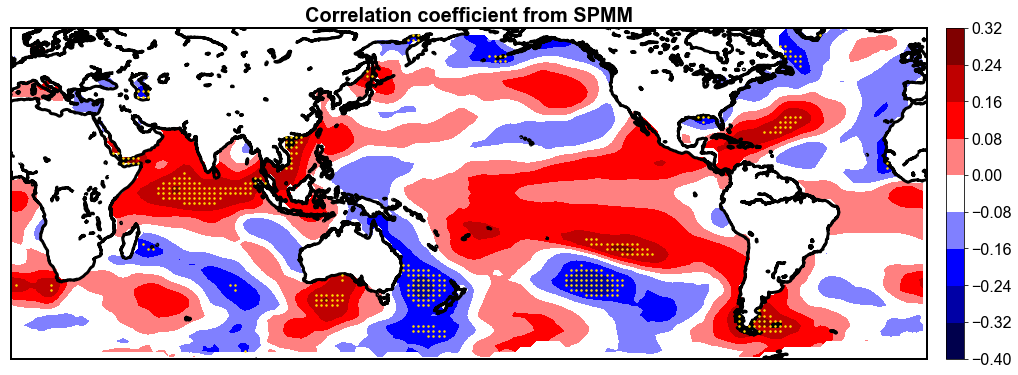

In [241]:
x, y= np.meshgrid(SST['lons'],SST['lats'])
stipple= ((pvalsSPMM<0.05) | (pvalsSPMM>0.95))
visualize(x, y, corrSPMM.reshape(89,180, order='F'), stipple= stipple.reshape(89,180, order='F'),
          cmap='viridis', title='Correlation coefficient from SPMM');

Fig.6 Correlation coefficient from predictor SPMM with yellow stupples standing for 95% significance with Monte Carlo test.

(b) Now calculate the correlation between the two FMA-averaged meridional mode indices. Are these
“independent-enough” predictors for SSTa? Briefly explain your reasoning (HINT: Consider the r2 values in
addition to r).

Use null-hypothesis to test if FMA-averaged NPMM and SPMM are correlated or not.

In [249]:
#compute degree of freedom

s_x = 1. # The index is standardized, so it's standard deviation is 1.
s_y = 1 #The standard deviation of y (i.e., SLP) as a function of space

# Lag-1 autocorrelation for the NPMM index
r1 = np.dot(fmaNPMM[:-1,None].T,fmaNPMM[1:,None])/float(len(fmaNPMM)-1)/s_x/s_x

# Lag-1 correlation matrix of the SPMM. 
r2 = np.dot(fmaSPMM[:-1,None].T,fmaSPMM[1:,None])/float(len(fmaSPMM)-1)/s_y/s_y

Neff = len(y)*(1-r1*r2)/(1+r1*r2)

# Round DOWN (remember - be conservative with your estimates)
Neff = np.fix(Neff)



r= np.dot(fmaNPMM.T, fmaSPMM)/float(len(fmaNPMM)-1)

tscore = r*np.sqrt(Neff-2)/np.sqrt(1-r**2)
pval = 2*stats.t.cdf(-abs(tscore),Neff-2)

print('correlation coefficient: %.2f, R^2: %.2f, significance level: %.2f'%(r, r**2, pval))

correlation coefficient: 0.20, R^2: 0.04, significance level: 0.06


Based on the result, if we select the p<0.05 as the threshold to reject this hypothesis, then this hypothesis is accepted that NPMM and SPMM are independent. Also, the R^2 illustrates their correlaiton is relatively weak.

(c) Regardless of your answer to (b), build a functional form of the general least-squares model: y=Ex+n. Sketch/describe what each vector/matrix y, E and x represents (e.g. what will be in the columns of E?)

$$SST=a*NPMM+b*SPMM+c$$

where c is the noise

Relating to the general formula, $E$ stores all the input data. For instance, E[:,0] is the constant c, E[:,1] is the FMA-averaged NPMM, and last column is the FMA-averaged-SPMM. X is where the coefficients stored (weights).

In [444]:
def multiRegressor(target, X):
    '''
    linear multi-regressor
    
    Args:
    --------------------
    :target - np.ndarray; y
    :X - np.ndarray/tuple; shape of (n_regressor, t, None)
    
    Returns:
    -------------------
    :xhat - np.ndarray; coefficient
    :yreconstruct - np.ndarray; reconstructed y
    '''
    
    n_regressors, t= X.shape
    E= np.zeros((t, n_regressors+1))
    E[:, 0]= 1
    for i in range(n_regressors):
        E[:,i+1]= X[i, np.arange(t)]
    
    xhat = np.linalg.inv(np.transpose(E).dot(E)).dot(E.T).dot(target)
    yreconstruct= E.dot(xhat)
    
    return xhat, yreconstruct

def reconstruct(xhat, X):
    '''
    reconstruct yhat based on given coefficients
    '''
    n_regressors, t= X.shape
    E= np.zeros((t, n_regressors+1))
    E[:, 0]= 1
    for i in range(n_regressors):
        E[:,i+1]= X[i, np.arange(t)]
    
    return E.dot(xhat)

def leave_one_out(predictors, target):
    '''
    The implementation of leave-one-out verification
    
    Args:
    -----------------
    :predictors - np.ndarray; shape of (n_regressor, space)
    :target - np.ndarray; shape of (time, space)
    
    returns:
    -----------------
    :forecast - np.ndarray;
    '''
    T, N= target.shape
    forecast= np.zeros((T, N))*np.nan
    for i in range(T):
        xCal= np.delete(predictors, i, axis=1)
        yCal= np.delete(target, i, axis=0)
        xhat, yRec= multiRegressor(yCal, xCal)
        #forecast
        forecast[i]= reconstruct(xhat, predictors[:,i, None])
    
    return forecast

def ACC(f, v):
    '''
    Anomaly Correlation Coefficient
    
    Args:
    --------------
    :f - forecast anomaly; shape of (time, space)
    :v - observed anomaly; shape of (time, space)
    
    Reuturns:
    --------------
    :acc_score - shape of (N,)
    '''
    T,N= f.shape
    acc_score= np.array([(f[:,i]*v[:,i]).sum()/((f[:,i]**2).sum()**.5)/((v[:,i]**2).sum()**.5) for i in range(N)])
    
    return acc_score

def monteCarloTest_acc(trials, x, y, acc):
    '''Monte Carlo simulations for testing the significance of ACC score'''
    n= trials
    T, N= y.shape
    mcAcc= np.zeros((n, N))*np.nan
#     taxis= np.arange(T)
    for i in range(n):
        print('%d/%d'%(i,n), flush=True)
        taxis= np.random.choice(T, int(2*T/3))
        predictors= x[:,taxis]
        target= y[taxis,:]
        forecast= leave_one_out(predictors, target)
        mcAcc[i,:]= ACC(forecast, target)
        mcAcc[i][mcAcc[i]<0]= np.nan
        
        
    pvals = np.array([stats.percentileofscore(mcAcc[:,i], acc[i])/100. for i in range(len(acc))])
    return pvals

In [442]:
taxis= np.arange(len(forecast))
np.random.shuffle(taxis)
x= predictors[:, taxis]
y= ndjSSTa[taxis,:]
forecast= leave_one_out(x, y)
acc= ACC(forecast, y)

In [465]:
predictors= np.vstack([fmaNPMM, fmaSPMM])

In [466]:
forecast= leave_one_out(predictors, ndjSSTa)

In [467]:
acc_score= ACC(forecast, ndjSSTa)
acc_score[acc_score<0]= np.nan

In [ ]:
pvals= monteCarloTest_acc(1000, predictors, ndjSSTa, acc_score)

Monte Carlo simulation

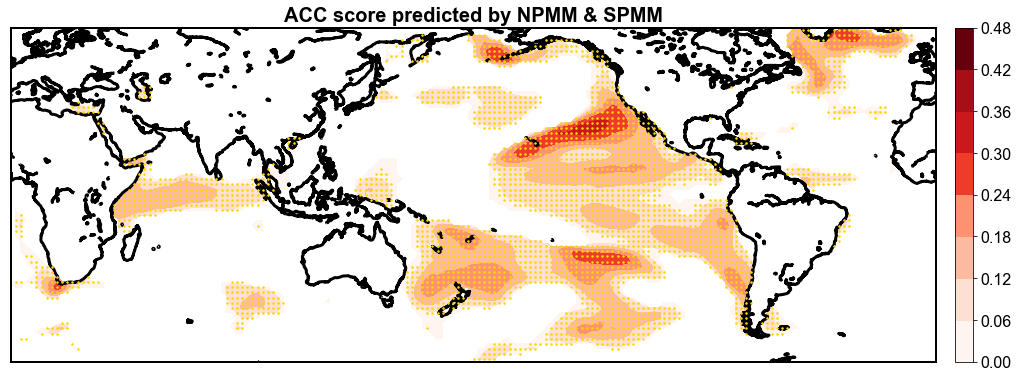

In [492]:
x, y= np.meshgrid(SST['lons'],SST['lats'])
stipple= (pvals>.05)
visualize(x, y, acc_score.reshape(89,180, order='F'), stipple= stipple.reshape(89,180, order='F'),
          cmap='Reds', title='ACC score predicted by NPMM & SPMM');

Fig. 7 Anamoly Correlation Coefficient (ACC) score predicted by NPMM and SPMM based on leave-one-out verification results. The stippled points are computed with Monte Carlo simulation with 0.05 significance level.

__F-test__:

In this study, I used F-test to validate the variance between forecast results and observation resutls because it is suitable for testing the variance especially in the model fitting context.

In [477]:
#compute degree of freedom

s_x = np.nanstd(forecast,axis=0) 
s_y = np.nanstd(ndjSSTa,axis=0) 

# Lag-1 autocorrelation for the NPMM index
r1 = np.dot(forecast[:-1].T,forecast[1:])/float(len(forecast)-1)/s_x/s_x

# Lag-1 correlation matrix of the SPMM. 
r2 = np.dot(ndjSSTa[:-1].T,ndjSSTa[1:])/float(len(ndjSSTa)-1)/s_y/s_y

Neff = len(y)*(1-r1*r2)/(1+r1*r2)

# Round DOWN (remember - be conservative with your estimates)
Neff = np.fix(Neff)


# pval = 2*stats.f.cdf(-abs(tscore),Neff-2)

In [485]:
fscore= np.nanvar(forecast, axis=0)/np.nanvar(ndjSSTa, axis=0)

In [489]:
pval= scipy.stats.f.cdf(fscore, len(forecast)-1, len(ndjSSTa)-1)

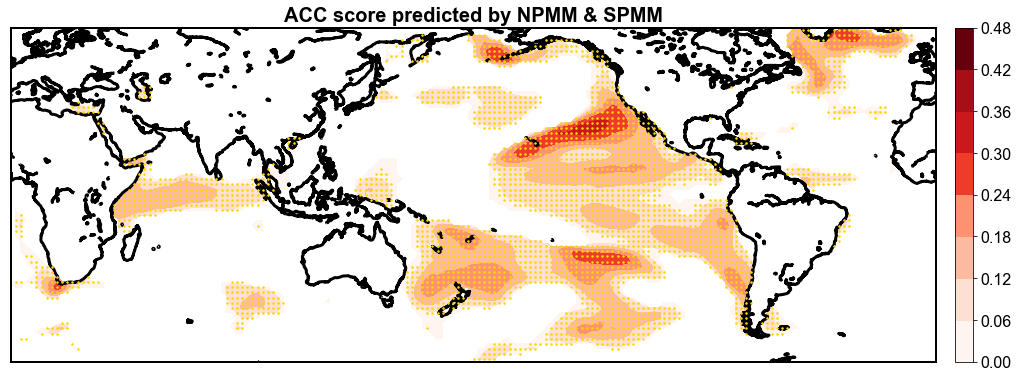

In [491]:
x, y= np.meshgrid(SST['lons'],SST['lats'])
stipple= (pvals>0.05)
visualize(x, y, acc_score.reshape(89,180, order='F'), stipple= stipple.reshape(89,180, order='F'),
          cmap='Reds', title='ACC score predicted by NPMM & SPMM');

Fig.8 Anamoly Correlation Coefficient (ACC) score predicted by NPMM and SPMM based on leave-one-out verification results. The stippled points are computed with F-test with 0.05 significance level.

In summary, both F-test and monte carlo simulation give consistent results, suggesting that the model has higher confidence in predicting areas in the northeast and southeast Pacific basin while relatively low skill in west part.